# Relating the salinity, mass loss, and current data

In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from mpl_toolkits.axes_grid1 import make_axes_locatable

ModuleNotFoundError: No module named 'seaborn'

### Making the Greenland a 2 column df with same date format

In [13]:
mass_file_path = '../data/greenland-mass-balance.csv'


In [14]:
mass_df = pd.read_csv(mass_file_path, skiprows=6)

# Rename for clarity
mass_df = mass_df.rename(columns={
    'Year': 'year',
    'IMBIE - Greenland cumulative mass balance': 'greenland_mass_loss'
})

# Convert decimal year to timestamp (month granularity)
def decimal_year_to_date(decimal_year):
    if pd.isnull(decimal_year):
        return pd.NaT
    year = int(decimal_year)
    fraction = decimal_year - year
    month = int(fraction * 12) + 1
    if month > 12:
        month = 12
    return pd.Timestamp(year=year, month=month, day=1)

# Apply the conversion
mass_df['year'] = mass_df['year'].apply(decimal_year_to_date)

# Replace 'year' with 'date'
mass_df = mass_df[['year', 'greenland_mass_loss']]

mass_df

,year,greenland_mass_loss
0,1992-01-01,458.7701
1,1992-01-01,458.1229
2,1992-03-01,457.4756
3,1992-04-01,456.8284
4,1992-04-01,456.1812
...,...,...
564,2023-02-01,NaN
565,2023-03-01,NaN
566,2023-04-01,NaN
567,2023-05-01,NaN


### Making current data a 2 column df with same date format

In [15]:

current_file_path = '../data/arctic_current_magnitude_timeseries.csv'


current_df = pd.read_csv(current_file_path)

# Rename for clarity and keep only the two relevant columns
current_df = current_df.rename(columns={
    'time': 'year',
    'mean_current_magnitude': 'current'
})[['year', 'current']]

current_df['year'] = pd.to_datetime(current_df['year'], errors='coerce')
current_df['year'] = current_df['year'].dt.date

# Show the final result
current_df

,year,current
0,2004-01-16,0.077361
1,2004-02-15,0.077698
2,2004-03-16,0.081676
3,2004-04-16,0.079294
4,2004-05-16,0.075287
...,...,...
235,2023-08-16,0.075759
236,2023-09-16,0.081039
237,2023-10-16,0.086767
238,2023-11-16,0.084582


### Making salinity data a 2 column df with same date format

### Plotting the data

In [16]:

salinity_file_path = 'greenland_smoothed_anomaly.csv'


salinity_df = pd.read_csv(salinity_file_path)

# Rename for clarity and keep only the two relevant columns

salinity_df = salinity_df.rename(columns={
    'time': 'year',
    'salinity_anomaly': 'salinity'
    })[['year', 'salinity']]

# Show the final result
salinity_df

,year,salinity
0,2004-07-01,0.016405
1,2004-08-01,0.015813
2,2004-09-01,0.014662
3,2004-10-01,0.013456
4,2004-11-01,0.012134
...,...,...
164,2018-03-01,-0.034254
165,2018-04-01,-0.034136
166,2018-05-01,-0.033532
167,2018-06-01,-0.032826


In [29]:
def normalize_year_column(df):
    if 'year' not in df.columns:
        df = df.reset_index()
    if 'year' not in df.columns:
        for col in df.columns:
            if 'date' in col.lower() or 'year' in col.lower():
                df = df.rename(columns={col: 'year'})
                break
    df['year'] = pd.to_datetime(df['year'])
    return df

# Apply this to all your datasets
mass_df = normalize_year_column(mass_df)
salinity_df = normalize_year_column(salinity_df)
current_df = normalize_year_column(current_df)

In [30]:
# === Remove duplicates from mass loss ===
mass_df = mass_df.drop_duplicates(subset='year')

# === Create uniform monthly index and interpolate mass loss from 2004 onward ===
uniform_index = pd.date_range(start='2004-01-01', end=mass_df['year'].max(), freq='MS')
mass_df = mass_df.set_index('year').sort_index()
mass_df = mass_df.reindex(uniform_index)
mass_df['greenland_mass_loss'] = mass_df['greenland_mass_loss'].interpolate(method='linear')
mass_df = mass_df.reset_index().rename(columns={'index': 'year'})


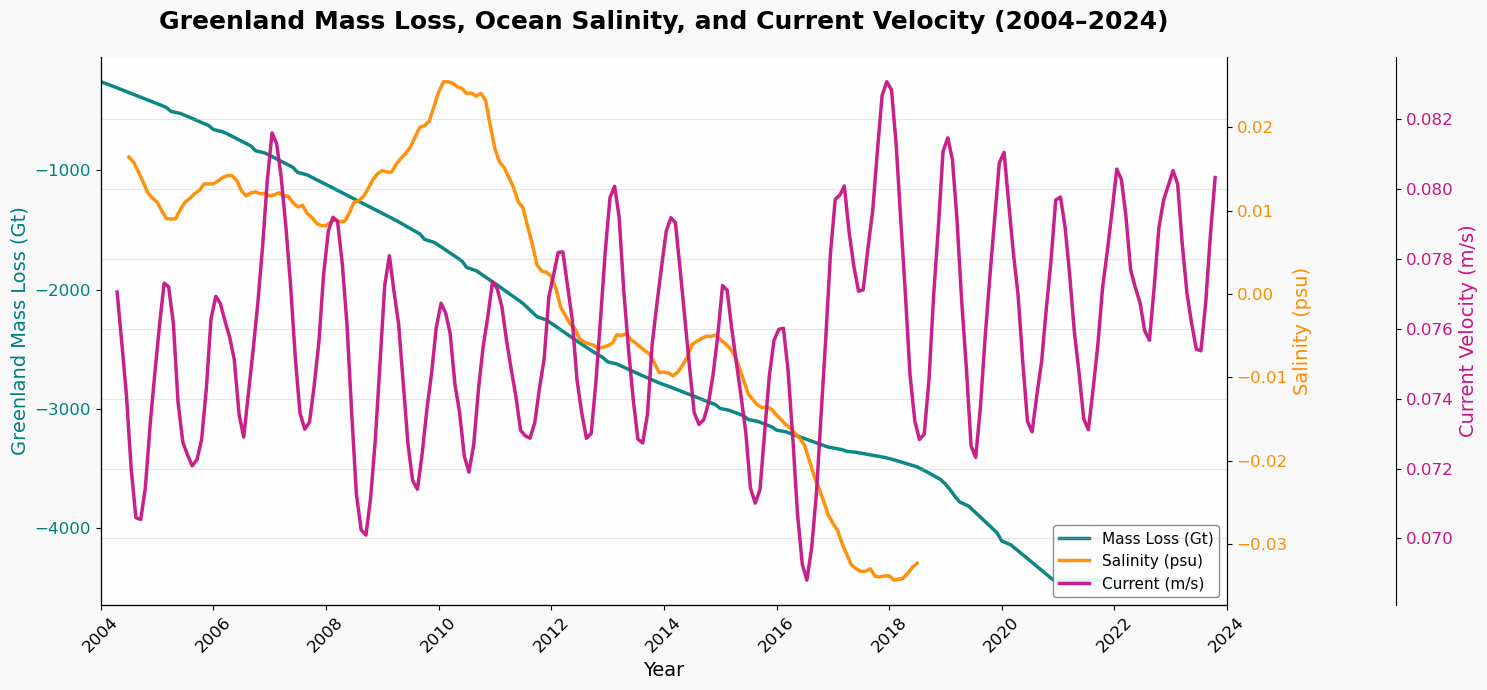

In [34]:
plt.rcParams["font.family"] = "DejaVu Sans"  # Or use 'Helvetica' if installed
plt.rcParams["axes.titlesize"] = 18
plt.rcParams["axes.labelsize"] = 14
plt.rcParams["xtick.labelsize"] = 12
plt.rcParams["ytick.labelsize"] = 12

# === Smooth current only ===
current_df['current_smooth'] = current_df['current'].rolling(window=6, center=True).mean()

# === Smooth current ===
current_df['current_smooth'] = current_df['current'].rolling(window=6, center=True).mean()

# === Plot ===
fig, ax1 = plt.subplots(figsize=(14, 7))
fig.patch.set_facecolor('#f9f9f9')       # Soft plot background
ax1.set_facecolor('#fefefe')             # Axes panel background

# --- Mass Loss ---
ax1.plot(mass_df['year'], mass_df['greenland_mass_loss'],
         color='teal', linewidth=2.5, alpha=0.95, label='Mass Loss (Gt)')
ax1.set_ylabel('Greenland Mass Loss (Gt)', color='teal')
ax1.tick_params(axis='y', labelcolor='teal')

# --- Salinity ---
ax2 = ax1.twinx()
ax2.plot(salinity_df['year'], salinity_df['salinity'],
         color='darkorange', linewidth=2.5, alpha=0.95, label='Salinity (psu)')
ax2.set_ylabel('Salinity (psu)', color='darkorange')
ax2.tick_params(axis='y', labelcolor='darkorange')

# --- Current Velocity (Smoothed) ---
ax3 = ax1.twinx()
ax3.spines["right"].set_position(("axes", 1.15))
ax3.plot(current_df['year'], current_df['current_smooth'],
         color='mediumvioletred', linewidth=2.5, alpha=0.95, label='Current (m/s)')
ax3.set_ylabel('Current Velocity (m/s)', color='mediumvioletred')
ax3.tick_params(axis='y', labelcolor='mediumvioletred')

# --- Shared x-axis formatting ---
ax1.set_xlim(pd.Timestamp('2004-01-01'), mass_df['year'].max())
ax1.set_xlabel("Year")
plt.title("Greenland Mass Loss, Ocean Salinity, and Current Velocity (2004–2024)",
          fontsize=18, fontweight='bold', pad=20)

# --- Unified Legend ---
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
lines3, labels3 = ax3.get_legend_handles_labels()
ax1.legend(lines1 + lines2 + lines3,
           labels1 + labels2 + labels3,
           loc='lower right', fontsize=11, frameon=True,
           facecolor='white', framealpha=0.9, edgecolor='gray')

# --- Layout polish ---
ax1.spines['top'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax3.spines['top'].set_visible(False)

xticks = pd.date_range(start='2004-01-01', end='2024-01-01', freq='2YS')
ax1.set_xticks(xticks)
ax1.set_xticklabels([d.strftime('%Y') for d in xticks], rotation=45)

fig.tight_layout()
fig.subplots_adjust(right=0.88)
plt.grid(alpha=0.3)
plt.show()


In [52]:
# === Step 2: Sort and compute mass loss rate ===
mass_df = mass_df.sort_values(by='year')
mass_df['mass_loss_rate'] = mass_df['greenland_mass_loss'].diff()

# === Step 3: Merge on 'year' AFTER rate is computed ===
merged_df = pd.merge(mass_df[['year', 'mass_loss_rate']], 
                     salinity_df[['year', 'salinity']], on='year', how='inner')
merged_df = pd.merge(merged_df, 
                     current_df[['year', 'current_smooth']], on='year', how='inner')

# === Step 4: Drop NaNs from smoothing or diff() ===
merged_df = merged_df.dropna()


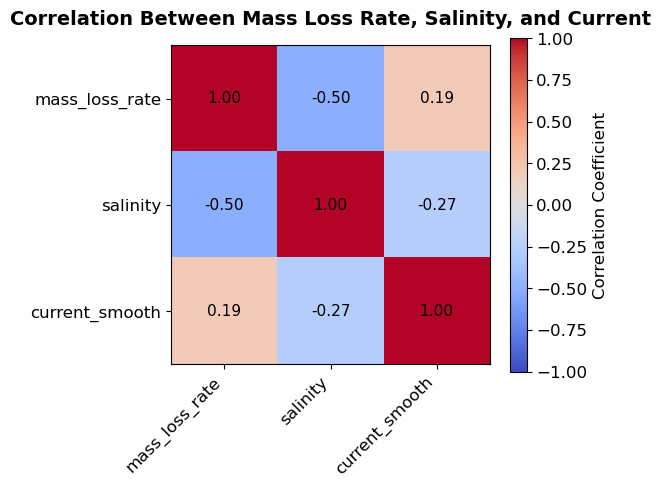

In [54]:
merged_df['mass_loss_rate'] = pd.to_numeric(merged_df['mass_loss_rate'], errors='coerce')
merged_df['salinity'] = pd.to_numeric(merged_df['salinity'], errors='coerce')
merged_df['current_smooth'] = pd.to_numeric(merged_df['current_smooth'], errors='coerce')

# === Step 6: Compute correlation matrix ===
corr_matrix = merged_df[['mass_loss_rate', 'salinity', 'current_smooth']].corr()

# === Step 7: Plot heatmap (pure matplotlib) ===
fig, ax = plt.subplots(figsize=(6, 5))
im = ax.imshow(corr_matrix.values, cmap='coolwarm', vmin=-1, vmax=1)

# Axis labels
ax.set_xticks(np.arange(len(corr_matrix.columns)))
ax.set_yticks(np.arange(len(corr_matrix.columns)))
ax.set_xticklabels(corr_matrix.columns, fontsize=12, rotation=45, ha='right')
ax.set_yticklabels(corr_matrix.columns, fontsize=12)

# Cell annotations
for i in range(len(corr_matrix.columns)):
    for j in range(len(corr_matrix.columns)):
        value = corr_matrix.iloc[i, j]
        ax.text(j, i, f"{value:.2f}", ha='center', va='center', color='black', fontsize=11)

# Title and colorbar
plt.title("Correlation Between Mass Loss Rate, Salinity, and Current", fontsize=14, fontweight='bold', pad=15)
cbar = plt.colorbar(im, ax=ax)
cbar.set_label("Correlation Coefficient", fontsize=12)

plt.tight_layout()
plt.show()
